In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import pygad



## Utils

In [2]:
def solution_to_matrixes(solution, num_doctor1, num_doctor2, num_nurse, num_faculties, num_days):
    """
    Args:
        solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
    Returns:
        A: 3D ndarray of shape (num_doctor1, num_faculties, num_days)
        B: 3D ndarray of shape (num_doctor2, num_faculties, num_days)
        C: 3D ndarray of shape (num_nurse, num_faculties, num_days)
    """
    # A = solution[:self.num_doctor1 * self.num_faculties * self.num_days].reshape(self.num_doctor1, self.num_faculties, self.num_days)
    # B = solution[self.num_doctor1 * self.num_faculties * self.num_days:(self.num_doctor1 + self.num_doctor2) * self.num_faculties * self.num_days].reshape(self.num_doctor2, self.num_faculties, self.num_days)
    # C = solution[(self.num_doctor1 + self.num_doctor2) * self.num_faculties * self.num_days:].reshape(self.num_nurse, self.num_faculties, self.num_days)

    A = solution[:num_doctor1 * num_faculties * num_days].reshape(num_doctor1, num_faculties, num_days)
    B = solution[num_doctor1 * num_faculties * num_days:(num_doctor1 + num_doctor2) * num_faculties * num_days].reshape(num_doctor2, num_faculties, num_days)
    C = solution[(num_doctor1 + num_doctor2) * num_faculties * num_days:].reshape(num_nurse, num_faculties, num_days)

    return A, B, C

def matrixes_to_solution(A, B, C):
    """
    Args:
        A: 3D ndarray of shape (num_doctor1, num_faculties, num_days)
        B: 3D ndarray of shape (num_doctor2, num_faculties, num_days)
        C: 3D ndarray of shape (num_nurse, num_faculties, num_days)
    Returns:
        solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
    """
    return np.concatenate([A.flatten(), B.flatten(), C.flatten()])


## Dataset Class

In [3]:
def read_to_numpy(file_path):
    df = pd.read_csv(file_path, index_col=False).reset_index()
    return df.to_numpy()

class Dataset:
    def __init__(self, doctor1_file_path, doctor2_file_path, nurse_file_path):
        self.doctor1_data = read_to_numpy(doctor1_file_path)
        self.doctor2_data = read_to_numpy(doctor2_file_path)
        self.nurse_data = read_to_numpy(nurse_file_path)
    
    def get_data(self):
        return self.doctor1_data, self.doctor2_data, self.nurse_data


In [4]:
dataset = Dataset('../data/doctor_1.csv', '../data/doctor_2.csv', '../data/nurse.csv')

## Fitness Function

In [5]:
class FitnessFunction:
    def __init__(self, num_faculties, num_days, dataset: Dataset, lambda1=0.1, lambda2=1, lambda3=1, lambda4=1, num_doctor1_per_day=1, num_doctor2_per_day=1, num_nurse_per_day=2):
        self.num_faculties = num_faculties
        self.num_days = num_days
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        self.lambda4 = lambda4
        self.dataset = dataset
        self.doctor1_data, self.doctor2_data, self.nurse_data = dataset.get_data()
        
        self.num_doctor1 = self.doctor1_data.shape[0]
        self.num_doctor2 = self.doctor2_data.shape[0]
        self.num_nurse = self.nurse_data.shape[0]

        self.num_doctor1_per_day = num_doctor1_per_day
        self.num_doctor2_per_day = num_doctor2_per_day
        self.num_nurse_per_day = num_nurse_per_day

    def soft_constraint_1(self, solution):
        """
        Idea: A day should be covered by all faculties
        => Penalize days that are not covered by all faculties (Add 1 for the number of faculties that are not covered for each day)

        Args:
            solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        Returns:
            float
        """
        A, B, C = solution_to_matrixes(solution, self.num_doctor1, self.num_doctor2, self.num_nurse, self.num_faculties, self.num_days)
        num_people_per_faculty_per_day = np.sum(np.concatenate([A, B, C], axis=0), axis=0) # shape: (num_faculties, num_days)
        num_faculty_per_day = np.sum(num_people_per_faculty_per_day!=0, axis=0) # shape: (num_days
        num_faculties_not_covered_per_day = self.num_faculties - num_faculty_per_day # shape: (num_days,)

        return np.sum(num_faculties_not_covered_per_day) # float

    def soft_constraint_4(self, solution):
        """
        Idea: Doctors and nurses should not work too much or too little
        => Penalize long consecutive working days for doctors and nurses

        Args:
            solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        Returns:
            float
        """
        A, B, C = solution_to_matrixes(solution, self.num_doctor1, self.num_doctor2, self.num_nurse, self.num_faculties, self.num_days)
        nurse_workload = np.sum(C, axis=2) # shape: (num_nurse, num_faculties)
        max_nurse_workload_diff = np.max(nurse_workload) - np.min(nurse_workload) # float

        both_doctor_workload = np.sum(np.concatenate([A, B], axis=0), axis=2) # shape: (num_doctor1 + num_doctor2, num_faculties)
        max_doctor_workload_diff = np.max(both_doctor_workload) - np.min(both_doctor_workload) # float

        return max_nurse_workload_diff + max_doctor_workload_diff # float
    
    def violate_hard_constraint(self, solution):
        """
        Idea: Every need to have self.num_doctor1_per_day doctor1, self.num_doctor2_per_day doctor2, self.num_nurse_per_day nurse
        Args:
            solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        Returns:
            bool
        """
        A, B, C = solution_to_matrixes(solution, self.num_doctor1, self.num_doctor2, self.num_nurse, self.num_faculties, self.num_days)
        num_doctor1_per_day = np.sum(A, axis=(0, 1)) # shape: (num_days,)
        num_doctor2_per_day = np.sum(B, axis=(0, 1))
        num_nurse_per_day = np.sum(C, axis=(0, 1))

        return np.any(num_doctor1_per_day != self.num_doctor1_per_day) or np.any(num_doctor2_per_day != self.num_doctor2_per_day) or np.any(num_nurse_per_day != self.num_nurse_per_day)
        
    def fitness_function(self, solution):
        """
        Args:
            solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        Returns:
            float
        """
        # return self.lambda1*self.soft_constraint_1(solution) + self.lambda4*self.soft_constraint_4(solution)
        if self.violate_hard_constraint(solution):
            print('Hard constraint violated')
            return -np.inf
        return -(self.lambda4*self.soft_constraint_4(solution))

In [6]:
_fitness_function = FitnessFunction(4, 61, dataset, lambda1=0.1, lambda2=1, lambda3=1, lambda4=1)

def fitness_func(ga_instance, solution, solution_idx):
    return _fitness_function.fitness_function(solution)

In [7]:
A = np.zeros((19, 4, 61))
B = np.zeros((17, 4, 61))
C = np.zeros((44, 4, 61))
solution = np.concatenate([A.flatten(), B.flatten(), C.flatten()])

## Population Generator


In [8]:
def generate_matrix_with_constraint(dim1, dim2, dim3, num_per_slice_dim3):
    """
    Args:
        dim1: int
        dim2: int
        dim3: int
        num_per_slice_dim3: int
    Returns:
        3D ndarray of shape (dim1, dim2, dim3)
    """
    matrix = np.zeros((dim1, dim2, dim3))
    for k in range(dim3):
        assigned_positions = set()
        for i in range(num_per_slice_dim3):
            i, j = np.random.randint(dim1), np.random.randint(dim2)
            while (i, j) in assigned_positions:
                i, j = np.random.randint(dim1), np.random.randint(dim2)
            matrix[i, j, k] = 1
            assigned_positions.add((i, j))
    return matrix


def generate_feasible_individual(num_faculties, num_days, num_doctor1, num_doctor2, num_nurse, num_doctor1_per_day, num_doctor2_per_day, num_nurse_per_day):
    A = generate_matrix_with_constraint(num_doctor1, num_faculties, num_days, num_doctor1_per_day)
    B = generate_matrix_with_constraint(num_doctor2, num_faculties, num_days, num_doctor2_per_day)
    C = generate_matrix_with_constraint(num_nurse, num_faculties, num_days, num_nurse_per_day)

    return matrixes_to_solution(A, B, C) # 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days

def generate_feasible_population(population_size, num_faculties, num_days, num_doctor1, num_doctor2, num_nurse, num_doctor1_per_day, num_doctor2_per_day, num_nurse_per_day):
    return [generate_feasible_individual(num_faculties, num_days, num_doctor1, num_doctor2, num_nurse, num_doctor1_per_day, num_doctor2_per_day, num_nurse_per_day) for _ in range(population_size)]


## Genetic Algorithm

In [9]:
class GeneticAlgorithm:
    def __init__(self, num_genes, num_generations=100, num_parents_mating=10, sol_per_pop=20, parent_selection_type="sss", crossover_type="single_point", mutation_type="random", mutation_percent_genes=10, fitness_func=fitness_func):
        self.num_generations = num_generations
        self.num_parents_mating = num_parents_mating
        self.sol_per_pop = sol_per_pop
        self.num_genes = num_genes
        self.parent_selection_type = parent_selection_type
        self.crossover_type = crossover_type
        self.mutation_type = mutation_type
        self.mutation_percent_genes = mutation_percent_genes
        self.fitness_func = fitness_func

    def setup(self, initial_population):
        self.ga_instance = pygad.GA(num_generations=self.num_generations,
                                    num_parents_mating=self.num_parents_mating,
                                    fitness_func=self.fitness_func,
                                    num_genes=self.num_genes,
                                    parent_selection_type=self.parent_selection_type,
                                    crossover_type=self.crossover_type,
                                    mutation_type=self.mutation_type,
                                    mutation_percent_genes=self.mutation_percent_genes,
                                    sol_per_pop=self.sol_per_pop,
                                    initial_population=initial_population,
                                    gene_space=[0, 1])

    def run(self):
        self.ga_instance.run()
        solution, solution_fitness, solution_idx = self.ga_instance.best_solution()
        print("Run finished!")
        print(f"Fitness value of the best solution: {solution_fitness}")
        return solution, solution_fitness, solution_idx

    def plot_results(self):
        self.ga_instance.plot_fitness()

In [10]:
algo = GeneticAlgorithm(num_genes=(19 + 17 + 44) * 4 * 61,
                        num_generations=200,
                        num_parents_mating=10,
                        sol_per_pop=50,
                        parent_selection_type="sss",
                        crossover_type="uniform",
                        mutation_type="random",
                        mutation_percent_genes=0.5,
                        fitness_func=fitness_func)
initial_population = generate_feasible_population(population_size=50, 
                                                  num_faculties=4, 
                                                  num_days=61, 
                                                  num_doctor1=19, 
                                                  num_doctor2=17, 
                                                  num_nurse=44, 
                                                  num_doctor1_per_day=1, 
                                                  num_doctor2_per_day=1, 
                                                  num_nurse_per_day=2,)
algo.setup(initial_population)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [11]:
solution, _, _ = algo.run()

Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated
Hard constraint violated


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


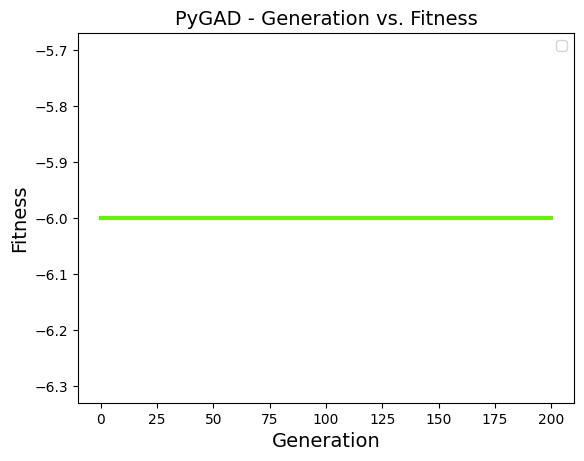

In [13]:
algo.plot_results()